# **テーマ**

一人一人の顔を検出してどんな顔をしているか観察する

In [1]:
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Yoloを使用しました

# **画像読み取り**

検出された顔の数: 20 faces


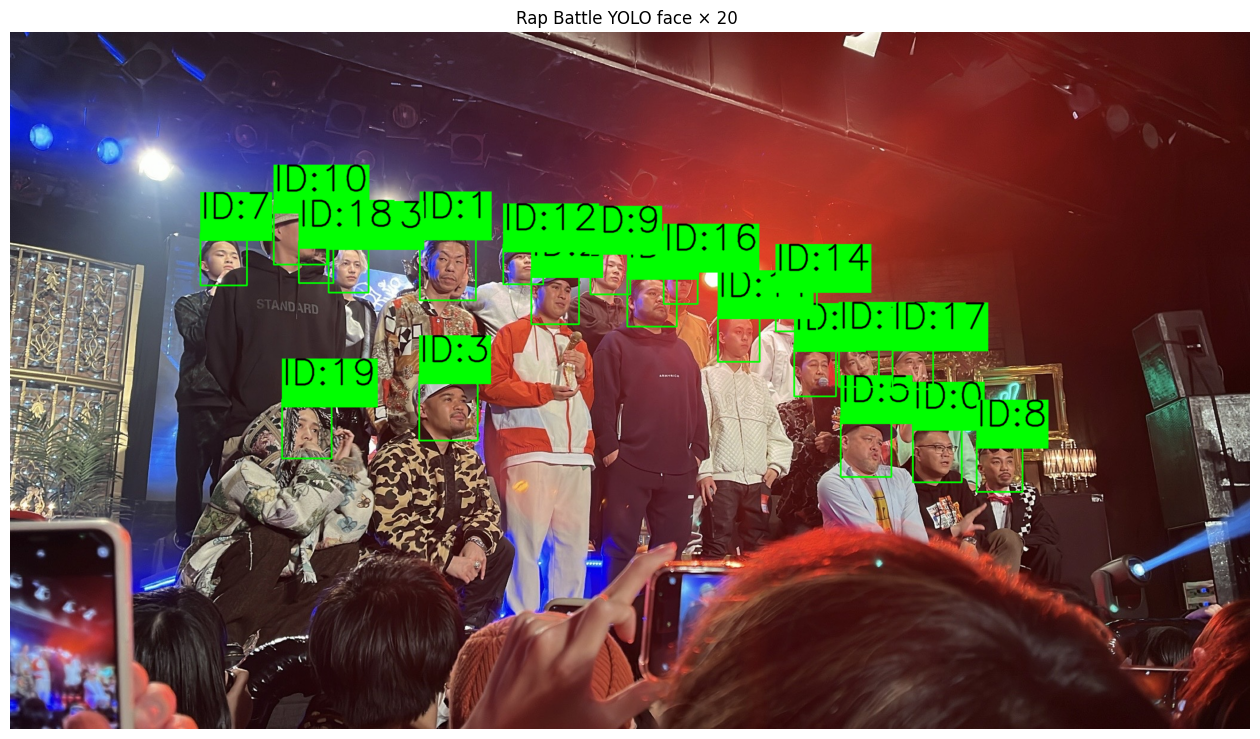

In [1]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
# ★ここを入力画像名に変更
image_path = Path("rapbattle.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論（imgsz を指定）
model = YOLO(model_path)
# sourceにstr(image_path)を渡すことで、指定した画像を読み込みます
result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))

# 画像が正しく読み込まれたかチェック
if annotated is None:
    print(f"エラー: 画像ファイル {image_path} を読み込めませんでした。ファイルパスを確認してください。")
    # プログラムを終了
    exit()

h_img, w_img = annotated.shape[:2]
color = (0,255,0)
font_scale = 2
thickness = 2

# 検出結果を描画（バッファ付き）
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1,y1,x2,y2 = map(int, box)
    w = x2 - x1; h = y2 - y1
    pad = int(max(w,h) * 0.2)  # バッファ 20%
    x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
    cv2.rectangle(annotated, (x1p,y1p), (x2p,y2p), color, thickness)
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    y_label = y1p-6 if y1p-6>h_label else y1p+h_label+6
    
    # ラベル背景の描画
    cv2.rectangle(annotated, (x1p, y_label-h_label-baseline), (x1p+w_label, y_label+baseline), color, -1)
    # ラベル文字の描画
    cv2.putText(annotated, label, (x1p, y_label-baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness, cv2.LINE_AA)

# 高解像度で保存（アップスケールして保存）
# ★ここを出力画像名に変更
output_path = Path("rapbattle_yolo_faces.jpg")
annot_up = cv2.resize(annotated, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)

# 結果の表示
detected_faces = len(result.boxes)
print(f"検出された顔の数: {detected_faces} faces")
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
# ★ここをタイトル名に変更
plt.title(f'Rap Battle YOLO face × {detected_faces} ')
plt.show()

コラージュを保存しました: rapbattle_faces_collage.jpg (faces: 20)


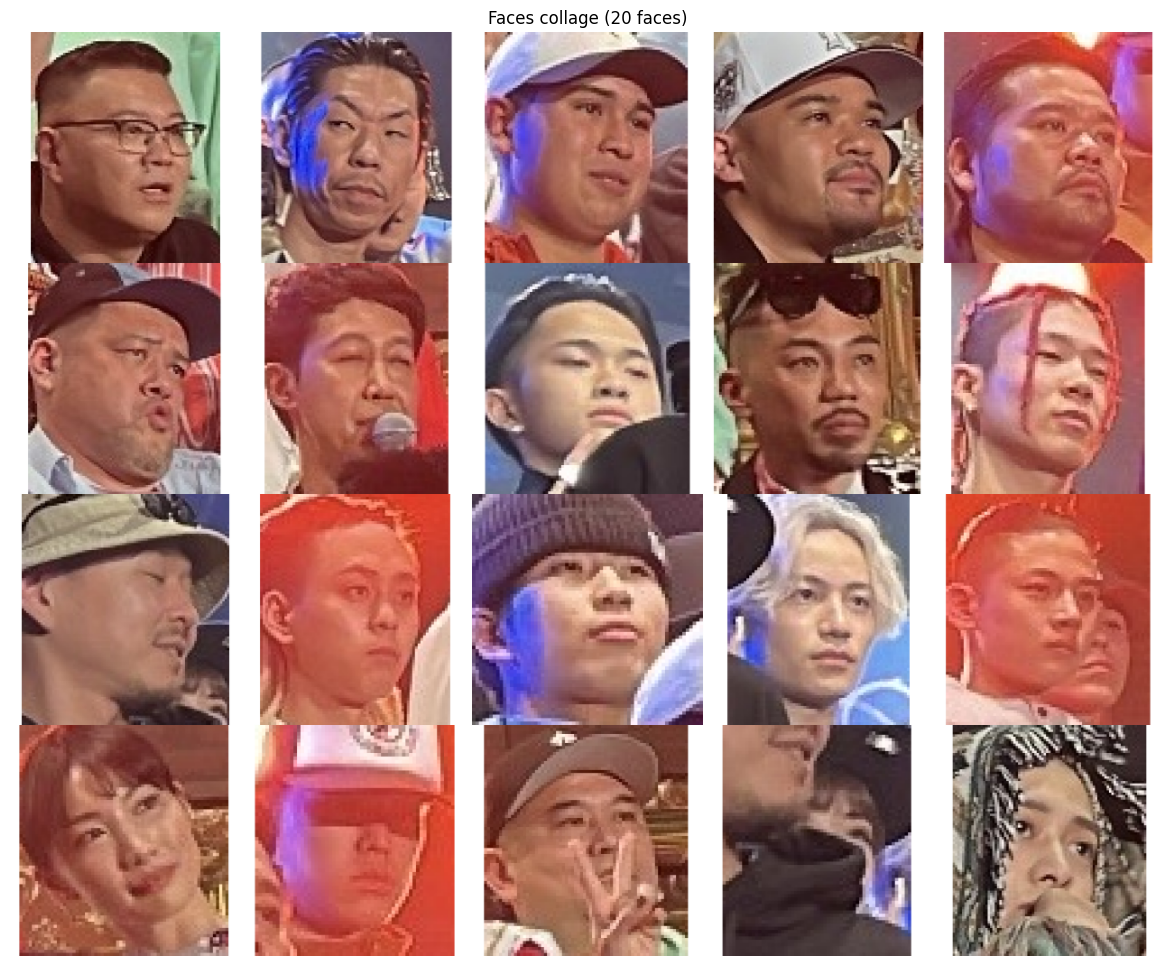

In [3]:
# 切り出した顔のコラージュを高解像度で作成（関数化）：collage_faces(image_path) を定義・実行
import cv2
import numpy as np
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt

def collage_faces(image_path):
    """
    collage_faces(image_path): YOLO で検出して顔を切り出し、コラージュを作成する関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    
    # ultralytics.YOLO を使用するには、ここでインポートが必要です (元のコードのまま)
    from ultralytics import YOLO 
    model = YOLO(model_path)
    
    # 検出を実行
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    faces = []
    tile = 256 # コラージュの1枚のサイズ

    # 検出された顔を一つずつ処理
    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        w = x2 - x1; h = y2 - y1
        pad = int(max(w, h) * 0.2) # バッファ 20%
        x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
        
        # 切り出し範囲が有効かチェック
        if x2p <= x1p or y2p <= y1p:
            continue
            
        crop = img[y1p:y2p, x1p:x2p]
        h_c, w_c = crop.shape[:2]
        size = max(h_c, w_c)
        
        # 正方形のキャンバスを作成し、顔を中央に配置（コラージュの見た目を整えるため）
        square = np.full((size, size, 3), 255, dtype=np.uint8) # 白いキャンバス
        y_off = (size - h_c)//2; x_off = (size - w_c)//2
        square[y_off:y_off+h_c, x_off:x_off+w_c] = crop
        
        # タイルサイズにリサイズしてリストに追加
        faces.append(cv2.resize(square, (tile, tile), interpolation=cv2.INTER_AREA))

    if len(faces) == 0:
        print('コラージュ用の顔が見つかりません')
        return None

    # コラージュのレイアウトを決定
    cols = min(5, len(faces)) # 最大5列
    rows = ceil(len(faces) / cols)
    
    # コラージュ用キャンバスを作成
    canvas = np.full((rows*tile, cols*tile, 3), 255, dtype=np.uint8)
    
    # コラージュに顔を配置
    for idx, f in enumerate(faces):
        r = idx // cols; c = idx % cols
        canvas[r*tile:(r+1)*tile, c*tile:(c+1)*tile] = f

    # ファイルに保存
    output_path = image_path.with_name(image_path.stem + '_faces_collage.jpg')
    cv2.imwrite(str(output_path), canvas)
    print(f'コラージュを保存しました: {output_path} (faces: {len(faces)})')
    
    # 結果を表示
    plt.figure(figsize=(16,12))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Faces collage ({len(faces)} faces)')
    plt.show()

# 関数を実行（rapbattle.jpg を引数として渡す）
collage_faces('rapbattle.jpg')

# **検出結果の分析**

この画像は高校生ラップ選手権での集合写真である

・みんなの顔を出力すると、みんな怖い顔をしていることがわかった。ラッパーはやはり怖い顔をすることがわかった
左の一列の人たちは、比較的笑顔で変顔をしている方もいます。この方々は審査員やゲストの方です。この方々はbattleに出場しないので笑顔だと考える。
・20人いることがわかる
・ID19はフードを被っているが、しっかりと検出されてる
　帽子を被っている人物もいるが、顔が検出されている

# **所感**

 ・一人一人がどのような顔をしているかを見ることができる。変顔や真面目、怖い顔、それぞれだれがどんな顔をしているかが一目でわかる。
・みんながどんな表情をしているのかを確認したいときに使うことができる。